In [6]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [7]:
cred = '{}'

In [5]:
#woorking with paths in python

from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(cred)
    cred_path.chmod(0o600)

In [8]:
#Download dataset from kaggle
path = Path('us-patent-phrase-to-phrase-matching')

In [9]:
#use kaggle API to download dataset to path & extract it
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

#### import and EDA

In [10]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

In [13]:
!ls {path}

sample_submission.csv test.csv              train.csv


In [14]:
import pandas as pd

In [15]:
datadf = pd.read_csv(path/'train.csv')

In [16]:
datadf

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [17]:
datadf.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


We observe that we have 36473 rows, with 733 unique anchors, 106 unique contxtand nearly 3000 targets. The mode for anchor is "componnet composite coating`" appearing 152 times.

In [18]:
datadf['input'] = 'TEXT1: ' + datadf.context + '; TEXT2: ' + datadf.target + ';ANC1: ' + datadf.anchor

In [19]:
datadf.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution;ANC1...
1    TEXT1: A47; TEXT2: act of abating;ANC1: abatement
2    TEXT1: A47; TEXT2: active catalyst;ANC1: abate...
3    TEXT1: A47; TEXT2: eliminating process;ANC1: a...
4     TEXT1: A47; TEXT2: forest region;ANC1: abatement
Name: input, dtype: object

##### Tokenization

In [20]:
#using hugging face dataset 

from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(datadf)

 

In [21]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [22]:
model_nm = 'microsoft/deberta-v3-small'

In [23]:
import sentencepiece

In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
tokz.tokenize("G'day hommies, I'm Ama from Apple!")

['▁G',
 "'",
 'day',
 '▁hom',
 'mies',
 ',',
 '▁I',
 "'",
 'm',
 '▁Ama',
 '▁from',
 '▁Apple',
 '!']

In [26]:
tokz.tokenize("A kwacoco is not the same as an iekwan anatinus.")

['▁A',
 '▁kwa',
 'coco',
 '▁is',
 '▁not',
 '▁the',
 '▁same',
 '▁as',
 '▁an',
 '▁i',
 'ek',
 'wan',
 '▁an',
 'at',
 'inus',
 '.']

In [27]:
#simple function to tokenize inpust
def tok_func(x): return tokz(x["input"])

In [28]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [29]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution;ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  64097,
  435,
  294,
  47284,
  2])

In [30]:
tokz.vocab['▁of']

265

In [31]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Now we've prepared our tokens and labels, we need to create our validatioin set

#### Test and validation sets

In [32]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [33]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

#### Test set

In [34]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

### Metrics and correlation

We would be using pearson correlation coefficient as our performance metric but before we proceed, it's important we 
understand what this metric is and how it used. 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame= True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [45]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [46]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [47]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906014

In [49]:
def show_corr(df, a,b):
    x, y = df[a], df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x,y):.2f}')

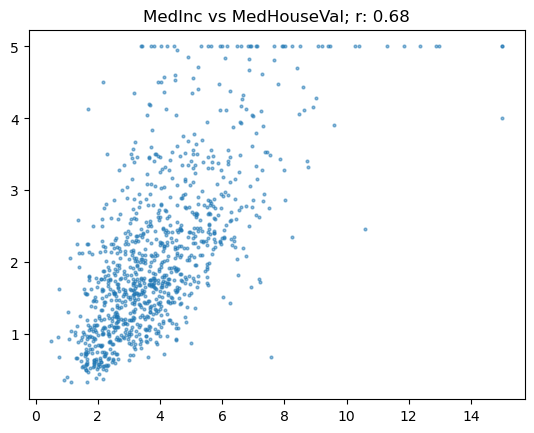

In [50]:
show_corr(housing, 'MedInc', 'MedHouseVal')

Let's remove outliers and try again

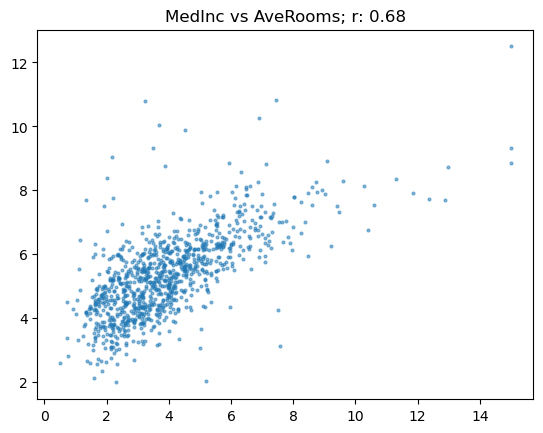

In [51]:
subset = housing[housing.AveRooms < 15]
show_corr(subset, 'MedInc', 'AveRooms')

In [ ]:
# we observe that the correlation is quiet similar to our first comparison

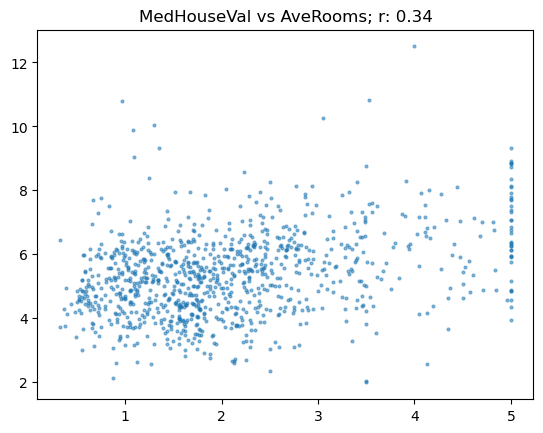

In [52]:
#another relatioinship using MedHouseVal and AveRooms
show_corr(subset, 'MedHouseVal', 'AveRooms')

In [53]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

#### Training

In [54]:
from transformers import TrainingArguments, Trainer

In [55]:
#we pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly
bs =128
epochs = 4

In [56]:
#learning rate 
lr = 8e-5

In [57]:
#set fp16 to False since we're not running on Nvidia CUDA device to avoid this error : 
#ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA devices.

args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=False,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [59]:
trainer.train()

/Users/ama/mambaforge/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025457,0.795565
2,No log,0.027216,0.822750
3,0.033200,0.022657,0.831471
4,0.033200,0.022373,0.833162


TrainOutput(global_step=856, training_loss=0.02495873085806303, metrics={'train_runtime': 21966.0159, 'train_samples_per_second': 4.981, 'train_steps_per_second': 0.039, 'total_flos': 716605488222960.0, 'train_loss': 0.02495873085806303, 'epoch': 4.0})